# Multiclass Classification

<h2> Short story </h2>

Most of the times we encounter problems that are not binary. E.x. imagine you're given a photo and your task it to predict if it contains a dog, cat, horse, duck etc.
Shortly you would like to assign each example to $1$ class of $k$ classes.

<h2> Naive way </h2>

Given k klasses the most naive way is to train k binary classifiers. We could then predict that an example x belongs to the class  𝑖={1,2,...,𝑘}  based on which classifier outputted the highest probability

## Smarter Way

There is a smarter way to go about this. We could force the output to be a discrete probability distribution over k classes.
​
To be a valid distribution the values of the output units
​
1) must be non-negative
​
2) must sum to 1
​
We can achieve this by applying the softmax function
​
$$softmax(z) = \frac{ e^{z} }{ \sum_{i=1}^{k} e^{ z_{i} } }$$
​
Each unit is exponetiated, therefore we force each unit to be positive
​
afterwards we have to normalize everything to 0-1

<h2> One hot vectors </h2>

A binary vector of length K, where each value is 0 except for the class it belongs, the value is 1.

$t_{nk} \in \{ 0,1 \}, \sum_{k=1}^{K} t_{nk} = 1$

Example of k=3 classes

\begin{equation}
\begin{bmatrix}
    1\\
    0\\
    0
\end{bmatrix},
\begin{bmatrix}
    0\\
    1\\
    0
\end{bmatrix},
\begin{bmatrix}
    0\\
    0\\
    1
\end{bmatrix}
\end{equation}

## Model

Likelihood
$$p( T | W ) = \sum_{n=1}^{N} \sum_{k=1}^{K} y_{nk}^{t_{nk}}$$

The cost function (logLikelihood plus reguralization term) we want to maximize for the problem of classifying N number of data in K categories/classes is:

$$
E(W) = \sum_{n=1}^N \sum_{k=1}^K t_{nk} \log y_{nk}   -  \frac{\lambda}{2} \sum_{k=1}^K ||\mathbf{w_k}||^2, 
$$

where $y_{nk}$ is the softmax function defined as:

$$y_{nk} = \frac{e^{\mathbf{w}_k^T \mathbf{x}_n}}{\sum_{j=1}^K e^{\mathbf{w}_j^T \mathbf{x}_n}}$$
$W$ is a $K \times (D+1)$ matrix where each line represents the vector $\mathbf{w}_k$.


The cost function can be simplified in the following form:



$$
E(W) = \sum_{n=1}^N \left[ \left( \sum_{k=1}^K t_{nk} \mathbf{w}_k^T \mathbf{x}_n \right) - \log \left( \sum_{j=1}^K e^{\mathbf{w}_j^T \mathbf{x}_n} \right) \right]   -  \frac{\lambda}{2} \sum_{k=1}^K ||\mathbf{w}_k||^2, 
$$



In the above formula we have used the fact that $\sum_{k=1}^K t_{nk} = 1$. 

The partial derrivatives of this function are given by the following $K \times (D+1)$ matrix:

$$
(T - S)^Τ X - \lambda W,
$$

where $T$ is an $N \times K$ matrix with the truth values of the training data, such that $[T]_{nk} = t_{nk}$, $S$ is the corresponding $N \times K$ matrix that holds the softmax probabilities such that $[S]_{nk} = y_{nk}$ and $X$ is the $N \times (D + 1)$ matrix of the input data

## Imports

In [1]:
import pandas as pd
import re
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import _pickle as cPickle
import random
import os
from pprint import pprint
from matplotlib import pyplot as plt

In [2]:
random.seed(0)

## Softmax

In [3]:
#use by default ax=1, when the array is 2D
#use ax=0 when the array is 1D
def softmax( x, ax=1 ):
    m = np.max( x, axis=ax, keepdims=True )#max per row
    p = np.exp( x - m )
    return ( p / np.sum(p,axis=ax,keepdims=True) )

2D case

In [4]:
z = np.array( [ [10,20,30,40], [20,50,45,45], [983,39,57,752], [574,575,597,525] ] )

In [5]:
z

array([[ 10,  20,  30,  40],
       [ 20,  50,  45,  45],
       [983,  39,  57, 752],
       [574, 575, 597, 525]])

In [6]:
pd.DataFrame( softmax( z ) )

,0,1,2,3
0,9.357198e-14,2.061060e-09,0.000045,9.999546e-01
1,9.233197e-14,9.867033e-01,0.006648,6.648354e-03
2,1.000000e+00,0.000000e+00,0.000000,4.764032e-101
3,1.026188e-10,2.789468e-10,1.000000,5.380186e-32


1D case

Let's take an example where all values are equal. As expected everything is 1 / |z|.

In [7]:
z = np.array( [1,1,1,1] )
softmax( z, ax=0 )

array([0.25, 0.25, 0.25, 0.25])

## Activation Functions (Tanh: 'tanh' , Cos: 'cos' , Softplus: 'softplus')

In [8]:
def softplus(X):
    return np.log(1 + np.exp(- np.abs(X))) + np.maximum(X, 0)  

In [9]:
def tanh(X):
    return np.tanh(X)  

In [10]:
def cos(X):
    return np.cos(X)

In [11]:
def derivative_softplus(X):
    return 1 / (1 + np.exp(- X))

In [12]:
def derivative_tanh(X):
    return 1 - np.power(np.tanh(X), 2)

In [13]:
def derivative_cos(X):
    return -(np.sin(X))

In [14]:
def activation_function(X):
    return non_linearity(X)

In [15]:
def derivative_activation_function(X):
    return derivative_function(X)

## MLP 

### Forward pass

In [16]:
def forward(X, t, weights_1, weights_2):
    # pass the input through the hidden layer
   
    
    a = activation_function(X.dot(weights_1.T))
    hidden = np.ones((a.shape[0], a.shape[1] + 1), dtype=float)
    hidden[:, 1:] = a
    
    y = hidden.dot(weights_2.T)

    y = softmax(y)

    loss = get_loss(t, y, weights_1, weights_2)

    return loss, y, hidden


In [17]:
def forward_keep_activations(X, weights_1, weights_2):
    # pass the input through the hidden layer
    #hidden_layer_representation = get_hidden_layer_representation(input, weights_1)
    
    a = activation_function(X.dot(weights_1.T))
    hidden = np.ones((a.shape[0], a.shape[1] + 1), dtype=float)
    hidden[:, 1:] = a
    
    # calculate dot product between weights_2 and hidden layer representation
    # hidden layer_representation : B x (M + 1)
    # weights_2 : K x (M + 1)
    y = hidden.dot(weights_2.T)

    # output now has dimensions: batch_size x K
    y = softmax(y)

    return y

### Backward pass

In [18]:
def backward(t, y, hidden_layer_rep, weights_1, weights_2, X):
    # gradients for the weights between the hidden layer and the softmax layer
    grad_weights_2 = (t - y).T.dot(hidden_layer_rep) - lamda * weights_2

    # remove the bias from weights_2
    weights_2_temp = np.copy(weights_2[:, 1:])

    derivative_result = derivative_activation_function(X.dot(weights_1.T))

    grad_weights_1_tmp = (t - y).dot(weights_2_temp) * derivative_result

    grad_weights_1 = grad_weights_1_tmp.T.dot(X) - lamda * weights_1

    return grad_weights_1, grad_weights_2

### Cost Function

For the cost function

$$
E(W) = \sum_{n=1}^N \left[ \left( \sum_{k=1}^K t_{nk} \mathbf{w}_k^T \mathbf{x}_n \right) - \log \left( \sum_{j=1}^K e^{\mathbf{w}_j^T \mathbf{x}_n} \right) \right]   -  \frac{\lambda}{2} \sum_{k=1}^K ||\mathbf{w}_k||^2, 
$$


we use the logsumexp trick, where m is the maximum element
\begin{align} 
\log \sum_{i=1}^{n} e^{\mathbf{w}_j^T \mathbf{x}_n} &= \log \Bigr( \sum_{i=1}^{n} e^{\mathbf{w}_j^T \mathbf{x}_n +m -m}\Bigl) \\ 
&= \log \Bigr( \sum_{i=1}^{n} e^m e^{\mathbf{w}_j^T \mathbf{x}_n-m} ) \Bigl) \\ 
&= \log \Bigr( e^m \sum_{i=1}^{n} e^{\mathbf{w}_j^T \mathbf{x}_n-m} ) \Bigl) \\ 
&= \log \ e^m + \log \Bigr( \sum_{i=1}^{n} e^{\mathbf{w}_j^T \mathbf{x}_n-m} ) \Bigl) \\ 
&= m + \log \Bigr( \sum_{i=1} e^{\mathbf{w}_j^T \mathbf{x}_n-m}  \Bigl) 
\end{align}

In [19]:
def get_loss(t, y, weights1, weights2):
    regularization = (lamda / 2) * (np.sum(np.square(weights1)) + np.sum(np.square(weights2)))
    y = np.log(y)
    y = t * y
    y = np.sum(y, 1)
    y = np.sum(y, 0)
    loss = y - regularization
    return loss

In [20]:
def batch_generate(data, data_labels):
    for idx in range(0, data.shape[0], batch_size):
        input_b = data[idx:idx + batch_size]
        labels_b = data_labels[idx:idx + batch_size]
        yield input_b, labels_b

### Training

Weight_2 (Output layer weights) initialized as zeros and the the Weight_1 (Hidden layer weights) randomly with normal distribution(m = 0 and s = 1)

In [21]:
def train():
    
    center = 0
    s = np.sqrt(1 / (D + 1))

    # Initialize the weights
    weights_2 = np.zeros((K, M + 1))
    weights_1 = np.random.normal(center, s, (M, D + 1))

    for _ in tqdm(range(epochs)):
        epoch_loss = []
        iterator = batch_generate(X_train, y_train)
        for batch in iterator:
            
            input_data = batch[0]
            labels = batch[1]

            ### forward pass 
            loss, output, hidden_layer_output = forward(input_data, labels, weights_1, weights_2)
            epoch_loss.append(loss)

            ### backward pass
            grad_weights_1, grad_weights_2 = backward(labels,output,hidden_layer_output,weights_1, weights_2,input_data)

            ### 
            weights_1 += lr * grad_weights_1
            weights_2 += lr * grad_weights_2

        print("Epoch average loss: ", sum(epoch_loss) / total_batches)
    
    return weights_1, weights_2 ,epoch_loss


In [22]:
def test_batch():
    # we do forward passes with the learned weights and we predict
    iterator = tqdm(batch_yielder(X_test, y_test))
    true = 0
    total = 0
    for batch in iterator:
        input_data = batch[0]
        labels = batch[1]

        ### forward
        output = forward_keep_activations(input_data, learned_weights_1, learned_weights_2)
        predictions = np.argmax(output, 1)
        labels = np.argmax(labels, 1)

        for idx in range(labels.shape[0]):
            if predictions[idx] == labels[idx]:
                true += 1
            total += 1

    print(true)
    print(total)
    print("Accuracy on Test : {}/{} ... {}".format(true, total, float(true / total)))

In [23]:
def predict():
    output = forward_keep_activations(X_test, learned_weights_1, learned_weights_2)
    pred= np.argmax(output, 1)
    accuracy = np.mean(pred == np.argmax(y_test, 1))
    print('Accuracy on Test Data  : {}'.format(accuracy))
    print("Writing to file: ")
    faults = np.where(np.not_equal(np.argmax(y_test,1),pred))[0]
    # plot n misclassified examples from the Test set
    n = 25
    samples = np.random.choice(faults, n)
    sqrt_n = int( n ** 0.5 )

    plt.figure( figsize=(11,13) )
    
    if (dataset=='MNIST'):
        cnt = 0
        for i in samples:
            cnt += 1
            plt.subplot( sqrt_n, sqrt_n, cnt )
            plt.subplot( sqrt_n, sqrt_n, cnt ).axis('off')
            plt.imshow( X_test[i,1:].reshape(28,28)*255, cmap='gray' )
            plt.title("True: "+str(np.argmax(y_test,1)[i])+ "\n Predicted: "+ str(pred[i]))

        plt.show()

### Datasets

#### Mnist Dataset

In the data folder there is the dataset of mnist. Mnists consists of $28x28$ grayscale images. In total there are 10 training files
train0.txt, train1.txt, ..., train9.txt where each rows of train$k$.txt corresponds to an example that belongs to the class $k$.

The testing data follows the same format.

In total we have $6*10^5$ training examples and $10^3$ testing examples

In [24]:
def load_mnist_data():
    train_files = ['train{}.txt'.format(i) for i in range(0, 10)]
    test_files = ['test{}.txt'.format(i) for i in range(0, 10)]
    print('Total train files: {}'.format(len(train_files)) + '\n' + 'Total test files: {}'.format(len(test_files)))

    data = []
    for idx, file in enumerate(train_files):
        with open(os.path.join(path, file), 'r') as train_file:
            data += train_file.readlines()
    train_data_tmp = np.array(np.array([[j for j in i.split(" ")] for i in data], dtype='int') / 255)
    print('Total training images with shape: ', train_data_tmp.shape)

    data = []
    for idx, file in enumerate(test_files):
        with open(os.path.join(path, file), 'r') as test_file:
            data += test_file.readlines()
    test_data_tmp = np.array(np.array([[j for j in i.split(" ")] for i in data], dtype='int') / 255)
    print('Total testing images with shape: ', test_data_tmp.shape)

    labels_data = []
    for idx, file in enumerate(train_files):
        with open(os.path.join(path, file), 'r') as train_file:
            for _ in train_file:
                labels_data.append([1 if i == idx else 0 for i in range(0, 10)])

    train_labels_tmp = np.array(labels_data, dtype='int')
    print('Total training labels: ', train_labels_tmp.shape)

    labels_data = []
    for idx, file in enumerate(test_files):
        with open(os.path.join(path, file), 'r') as test_file:
            for _ in test_file:
                labels_data.append([1 if i == idx else 0 for i in range(0, 10)])

    test_labels_tmp = np.array(labels_data, dtype='int')
    print('Total testing labels: ', test_labels_tmp.shape)

    return train_data_tmp, train_labels_tmp, test_data_tmp, test_labels_tmp

#### Cifar-10 Dataset

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research.[1][2] The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes.[3] The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class

In [25]:
def load_cifar_10_data():
    train_batches = ['data_batch_{}'.format(i) for i in range(1, 6)]
    data = []
    train_labels_tmp = np.zeros((50000, 10))

    batch_dicts = []
    for batch_name in train_batches:
        batch_dicts.append(load_cifar_10_batch(batch_name))

    img_idx = 0
    for batch_dict in batch_dicts:
        for img_data in batch_dict['data']:
            data.append(img_data)

        for img_label in batch_dict['labels']:
            train_labels_tmp[img_idx][img_label] = 1
            img_idx += 1

    train_data_tmp = np.asarray(data)
    train_data_tmp = train_data_tmp / 255

    test_batch_dict = load_cifar_10_batch('test_batch', True)
    data = []
    test_labels_tmp = np.zeros((10000, 10))
    for img in test_batch_dict['data']:
        data.append(img)

    img_idx = 0
    for img_label in test_batch_dict['labels']:
        test_labels_tmp[img_idx][img_label] = 1
        img_idx += 1

    test_data_tmp = np.asarray(data)
    test_data_tmp = test_data_tmp / 255

    print('Total training images with shape: ', train_data_tmp.shape)
    print('Total testing images with shape: ', test_data_tmp.shape)
    print('Total training labels: ', train_labels_tmp.shape)
    print('Total test labels: ', test_labels_tmp.shape)

    return train_data_tmp, train_labels_tmp, test_data_tmp, test_labels_tmp

In [26]:
def load_cifar_10_batch(batch_name, test_bool=False):
    #C:\Users\giann\Desktop\ergasia1\
    data_batch = cPickle.load(open(r'data\cifar-10-batches-py/{}'.format(batch_name), 'rb'),
                              encoding='latin1')

    return data_batch

### Visualizing the datasets

In [27]:
def plot_mnist(image_data):
    # plot 5 random images from the training set
    n = 100
    sqrt_n = int(n ** 0.5)
    samples = np.random.randint(x_train.shape[0], size=n)

    plt.figure(figsize=(11, 11))

    cnt = 0
    for i in samples:
        cnt += 1
        plt.subplot(sqrt_n, sqrt_n, cnt)
        plt.subplot(sqrt_n, sqrt_n, cnt).axis('off')
        plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
        
    img = x_train[50000].reshape(28, 28)

    fig = plt.figure(figsize = (12,12)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

    plt.show()

In [28]:
def plot_cifar(ind):
    arr = x_train[ind]
    R = arr[0:1024].reshape(32, 32)
    G = arr[1024:2048].reshape(32, 32)
    B = arr[2048:].reshape(32, 32)

    img = np.dstack((R, G, B))
    title = re.sub('[!@#$b]', '', str(labels_names[np.argmax(y_train[ind])]))
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot(111)
    ax.imshow(img, interpolation='bicubic')
    ax.set_title('Category = ' + title, fontsize=15)
    plt.show()

## Gradient checking


During gradient ascent/descent we compute the gradients $\frac{\partial E}{\partial w}$, where $w$ denotes the parameters of the model.

In order to make sure that these gradients are correct we will compare the exact gradients(that we have coded) with numerical estimates obtained by finite differences, you can use your code for computing $E$ to verify the code for computing $\frac{\partial E}{\partial w}$.
    Let's look back at the definition of a derivative (or gradient):
    
$$ \frac{\partial E}{\partial w} = \lim_{\varepsilon \to 0} \frac{E(w + \varepsilon) - E(w - \varepsilon)}{2 \varepsilon} \tag{1}$$  

We know the following: 
- $\frac{\partial E}{\partial w}$ is what you want to make sure you're computing correctly. ,
- You can compute $E(w + \varepsilon)$ and $E(w - \varepsilon)$ (in the case that $w$ is a real number), since you're confident your implementation for $E$ is correct.

Let's use equation (1) and a small value ( around $10^-4$ or $10^-6$, much smaller values could lead to numerical issues )for $\varepsilon$ to make sure that your code for computing  $\frac{\partial E}{\partial w}$ is correct!

In [29]:
def gradient_check():
    epsilon = 1e-6

    # create two random weight matrices
    weights_1_tmp = np.random.rand(M, D + 1) * np.sqrt(1 / (D + 1 + M))
    weights_2_tmp = np.random.rand(K, M + 1) * np.sqrt(1 / (M + 1 + K))

    weights_1_tmp[:, 0] = 1.0
    weights_2_tmp[:, 0] = 1.0

    # create a fake train batch (of size 8)
    b_size = 8
    fake_input = X_train[:b_size]
    fake_labels = y_train[:b_size]

    # calculate gradients with backpropagation
    loss, output, hidden_layer_output = forward(fake_input, fake_labels, weights_1_tmp, weights_2_tmp)
    grad_weights_1, grad_weights_2 = backward(fake_labels,
                                              output,
                                              hidden_layer_output,
                                              weights_1_tmp,
                                              weights_2_tmp,
                                              fake_input)

    # calculate gradients with two-sided epsilon method
    grad_check_for_w1 = np.zeros((M, D + 1))
    for i in tqdm(range(grad_check_for_w1.shape[0])):
        for j in range(grad_check_for_w1.shape[1]):
            w1 = np.copy(weights_1_tmp)
            w1[i, j] += epsilon
            e1, _, _ = forward(fake_input, fake_labels, w1, weights_2_tmp)

            w1 = np.copy(weights_1_tmp)
            w1[i, j] -= epsilon
            e2, _, _ = forward(fake_input, fake_labels, w1, weights_2_tmp)

            grad_check_for_w1[i, j] = (e1 - e2) / (2 * epsilon)

    # compute the difference for w1
    # it is the Euclidean distance normalized by the sum of the norms
    numerator = np.linalg.norm(grad_weights_1 - grad_check_for_w1)
    denominator = np.linalg.norm(grad_check_for_w1) + np.linalg.norm(grad_weights_1)
    difference = numerator / denominator
    print('The difference for weights_1 is: {}'.format(difference))

    grad_check_for_w2 = np.zeros((K, M + 1))
    for i in tqdm(range(grad_check_for_w2.shape[0])):
        for j in range(grad_check_for_w2.shape[1]):
            w2 = np.copy(weights_2_tmp)
            w2[i, j] += epsilon
            e1, _, _ = forward(fake_input, fake_labels, weights_1_tmp, w2)

            w2 = np.copy(weights_2_tmp)
            w2[i, j] -= epsilon
            e2, _, _ = forward(fake_input, fake_labels, weights_1_tmp, w2)

            grad_check_for_w2[i, j] = (e1 - e2) / (2 * epsilon)

    # compute the difference for w2
    # it is the Euclidean distance normalized by the sum of the norms
    numerator = np.linalg.norm(grad_weights_2 - grad_check_for_w2)
    denominator = np.linalg.norm(grad_check_for_w2) + np.linalg.norm(grad_weights_2)
    difference = numerator / denominator
    print('The difference for weights_2 is: {}'.format(difference))

### Selecting dataset 

In [30]:
dataset = input('Type "MNIST" for the mnist dataset, "CIFAR" or something else otherwise')

Type "MNIST" for the mnist dataset, "CIFAR" or something else otherwise MNIST


Total train files: 10
Total test files: 10
Total training images with shape:  (60000, 784)
Total testing images with shape:  (10000, 784)
Total training labels:  (60000, 10)
Total testing labels:  (10000, 10)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


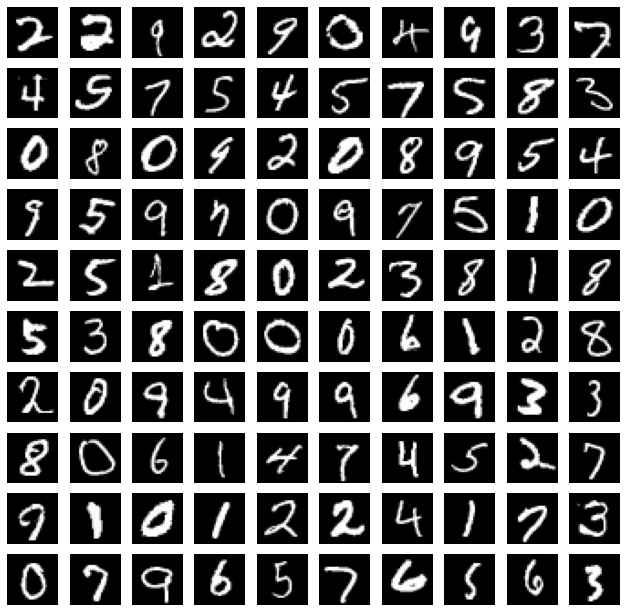

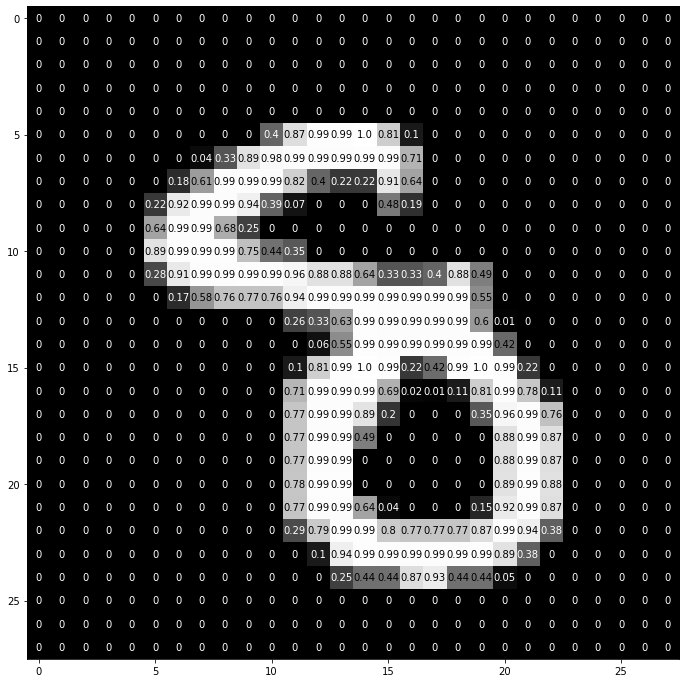

In [31]:
#dataset = 'MNIST'

if dataset == 'MNIST':
    #C:\Users\giann\Desktop\ergasia1\
    path = r'data\mnist'
    x_train, y_train, x_test, y_test = load_mnist_data()
    plot_mnist(x_train)
else:
    #C:\Users\giann\Desktop\ergasia1\
    path = r'data\cifar-10-batches-py'
    #C:\Users\giann\Desktop\ergasia1\
    labels_dict = cPickle.load(open(r'data\cifar-10-batches-py/{}'.format('batches.meta'), 'rb'))
    labels_names = labels_dict['label_names']
    x_train, y_train, x_test, y_test = load_cifar_10_data()

    # plot a random sample from the train set

    ind = np.random.randint(0, 50000)
    plot_cifar(ind)


In [67]:
batch_size = 100
epochs = 100
lr = 0.0007
lamda = 0.01
M = 100
D = x_train.shape[1]
print(D)
K = 10


inp = input('Type "tanh" or "cos" or "softplus" ')

if (inp == tanh):
    non_linearity = tanh
    derivative_function = derivative_tanh
elif (inp == cos):
    non_linearity = cos
    derivative_function = derivative_cos
else:
    non_linearity = softplus
    derivative_function = derivative_softplus

784


Type "tanh" or "cos" or "softplus"  tanh


### Data Preparation

In [33]:
X_train = np.ones((x_train.shape[0], x_train.shape[1] + 1), dtype=float)
X_train[:, 1:] = x_train

X_test = np.ones((x_test.shape[0], x_test.shape[1] + 1), dtype=float)
X_test[:, 1:] = x_test

### Data Shuffling

In [34]:
idx_list = [i for i in range(y_train.shape[0])]
shuffle(idx_list)
X_train = X_train[idx_list]
y_train = y_train[idx_list]
total_batches = X_train.shape[0] // batch_size

# we must also shuffle the test data
idx_list = [i for i in range(y_test.shape[0])]
shuffle(idx_list)
X_test = X_test[idx_list]
y_test = y_test[idx_list]




### Gradient Checking and Training 

In [68]:
print('--- Gradient Checking ---')
gradient_check()

learned_weights_1, learned_weights_2,loss = train()


  0%|          | 0/100 [00:00<?, ?it/s]

--- Gradient Checking ---


  1%|          | 1/100 [00:01<01:52,  1.14s/it]

Epoch average loss:  -86.12038218213468


  2%|▏         | 2/100 [00:02<01:50,  1.13s/it]

Epoch average loss:  -35.89438683903743


  3%|▎         | 3/100 [00:03<01:50,  1.14s/it]

Epoch average loss:  -32.081628068621555


  4%|▍         | 4/100 [00:04<01:53,  1.18s/it]

Epoch average loss:  -30.0023140270282


  5%|▌         | 5/100 [00:05<01:51,  1.17s/it]

Epoch average loss:  -28.23374584861484


  6%|▌         | 6/100 [00:06<01:47,  1.14s/it]

Epoch average loss:  -26.50908939412528


  7%|▋         | 7/100 [00:07<01:42,  1.10s/it]

Epoch average loss:  -24.85318431968152


  8%|▊         | 8/100 [00:09<01:41,  1.10s/it]

Epoch average loss:  -23.33353604951832


  9%|▉         | 9/100 [00:09<01:36,  1.06s/it]

Epoch average loss:  -21.96735331596027


 10%|█         | 10/100 [00:11<01:34,  1.05s/it]

Epoch average loss:  -20.741936592704857


 11%|█         | 11/100 [00:12<01:32,  1.04s/it]

Epoch average loss:  -19.641578691178243


 12%|█▏        | 12/100 [00:13<01:30,  1.03s/it]

Epoch average loss:  -18.654239386426294


 13%|█▎        | 13/100 [00:14<01:28,  1.02s/it]

Epoch average loss:  -17.769439842993577


 14%|█▍        | 14/100 [00:15<01:29,  1.04s/it]

Epoch average loss:  -16.976293261934867


 15%|█▌        | 15/100 [00:16<01:28,  1.04s/it]

Epoch average loss:  -16.26373370472401


 16%|█▌        | 16/100 [00:17<01:26,  1.03s/it]

Epoch average loss:  -15.62154931070619


 17%|█▋        | 17/100 [00:18<01:25,  1.02s/it]

Epoch average loss:  -15.040817976905588


 18%|█▊        | 18/100 [00:19<01:24,  1.03s/it]

Epoch average loss:  -14.513788342610997


 19%|█▉        | 19/100 [00:20<01:27,  1.08s/it]

Epoch average loss:  -14.033660121983663


 20%|██        | 20/100 [00:21<01:27,  1.10s/it]

Epoch average loss:  -13.594443470738247


 21%|██        | 21/100 [00:22<01:24,  1.07s/it]

Epoch average loss:  -13.190891311561499


 22%|██▏       | 22/100 [00:23<01:21,  1.05s/it]

Epoch average loss:  -12.818458062466322


 23%|██▎       | 23/100 [00:24<01:19,  1.04s/it]

Epoch average loss:  -12.473254222135575


 24%|██▍       | 24/100 [00:25<01:21,  1.07s/it]

Epoch average loss:  -12.151988706605332


 25%|██▌       | 25/100 [00:26<01:19,  1.07s/it]

Epoch average loss:  -11.851900620930008


 26%|██▌       | 26/100 [00:27<01:19,  1.07s/it]

Epoch average loss:  -11.57068475016441


 27%|██▋       | 27/100 [00:29<01:21,  1.12s/it]

Epoch average loss:  -11.30641600524484


 28%|██▊       | 28/100 [00:30<01:18,  1.10s/it]

Epoch average loss:  -11.057477982911422


 29%|██▉       | 29/100 [00:31<01:17,  1.09s/it]

Epoch average loss:  -10.822500200610541


 30%|███       | 30/100 [00:32<01:18,  1.12s/it]

Epoch average loss:  -10.600307190088705


 31%|███       | 31/100 [00:33<01:18,  1.14s/it]

Epoch average loss:  -10.38987986867233


 32%|███▏      | 32/100 [00:34<01:16,  1.13s/it]

Epoch average loss:  -10.19032676048407


 33%|███▎      | 33/100 [00:35<01:19,  1.18s/it]

Epoch average loss:  -10.000861729785997


 34%|███▍      | 34/100 [00:37<01:19,  1.20s/it]

Epoch average loss:  -9.820785845925014


 35%|███▌      | 35/100 [00:38<01:15,  1.16s/it]

Epoch average loss:  -9.649472280895392


 36%|███▌      | 36/100 [00:39<01:18,  1.22s/it]

Epoch average loss:  -9.486353835947314


 37%|███▋      | 37/100 [00:40<01:16,  1.21s/it]

Epoch average loss:  -9.330912868953233


 38%|███▊      | 38/100 [00:41<01:13,  1.18s/it]

Epoch average loss:  -9.182673376193526


 39%|███▉      | 39/100 [00:43<01:09,  1.14s/it]

Epoch average loss:  -9.041194941373009


 40%|████      | 40/100 [00:44<01:06,  1.11s/it]

Epoch average loss:  -8.906068229435924


 41%|████      | 41/100 [00:45<01:04,  1.09s/it]

Epoch average loss:  -8.776911681243604


 42%|████▏     | 42/100 [00:46<01:00,  1.05s/it]

Epoch average loss:  -8.653369080348261


 43%|████▎     | 43/100 [00:47<00:59,  1.05s/it]

Epoch average loss:  -8.535107720271396


 44%|████▍     | 44/100 [00:48<01:00,  1.07s/it]

Epoch average loss:  -8.421816975399299


 45%|████▌     | 45/100 [00:49<00:57,  1.05s/it]

Epoch average loss:  -8.31320714008556


 46%|████▌     | 46/100 [00:50<00:56,  1.05s/it]

Epoch average loss:  -8.209008435079893


 47%|████▋     | 47/100 [00:51<00:56,  1.07s/it]

Epoch average loss:  -8.108970094260973


 48%|████▊     | 48/100 [00:52<00:58,  1.13s/it]

Epoch average loss:  -8.012859452133643


 49%|████▉     | 49/100 [00:53<00:58,  1.15s/it]

Epoch average loss:  -7.920460963292644


 50%|█████     | 50/100 [00:55<00:57,  1.15s/it]

Epoch average loss:  -7.831575101258988


 51%|█████     | 51/100 [00:56<00:54,  1.12s/it]

Epoch average loss:  -7.746017106984025


 52%|█████▏    | 52/100 [00:57<00:52,  1.09s/it]

Epoch average loss:  -7.663615592651324


 53%|█████▎    | 53/100 [00:58<00:51,  1.09s/it]

Epoch average loss:  -7.584211058878418


 54%|█████▍    | 54/100 [00:59<00:49,  1.08s/it]

Epoch average loss:  -7.507654441405454


 55%|█████▌    | 55/100 [01:00<00:48,  1.08s/it]

Epoch average loss:  -7.433805833104421


 56%|█████▌    | 56/100 [01:01<00:47,  1.07s/it]

Epoch average loss:  -7.362533496092692


 57%|█████▋    | 57/100 [01:02<00:45,  1.06s/it]

Epoch average loss:  -7.293713192707117


 58%|█████▊    | 58/100 [01:03<00:44,  1.05s/it]

Epoch average loss:  -7.22722777187348


 59%|█████▉    | 59/100 [01:04<00:44,  1.08s/it]

Epoch average loss:  -7.162966899401622


 60%|██████    | 60/100 [01:05<00:42,  1.07s/it]

Epoch average loss:  -7.100826828798369


 61%|██████    | 61/100 [01:06<00:43,  1.11s/it]

Epoch average loss:  -7.0407101490856725


 62%|██████▏   | 62/100 [01:08<00:44,  1.17s/it]

Epoch average loss:  -6.982525487367889


 63%|██████▎   | 63/100 [01:09<00:45,  1.24s/it]

Epoch average loss:  -6.926187170519646


 64%|██████▍   | 64/100 [01:10<00:44,  1.22s/it]

Epoch average loss:  -6.871614861409386


 65%|██████▌   | 65/100 [01:11<00:40,  1.17s/it]

Epoch average loss:  -6.818733186192303


 66%|██████▌   | 66/100 [01:12<00:38,  1.12s/it]

Epoch average loss:  -6.767471366092701


 67%|██████▋   | 67/100 [01:13<00:36,  1.11s/it]

Epoch average loss:  -6.717762863175357


 68%|██████▊   | 68/100 [01:14<00:35,  1.11s/it]

Epoch average loss:  -6.669545046273141


 69%|██████▉   | 69/100 [01:15<00:33,  1.07s/it]

Epoch average loss:  -6.622758880733493


 70%|███████   | 70/100 [01:16<00:31,  1.07s/it]

Epoch average loss:  -6.577348643779512


 71%|███████   | 71/100 [01:17<00:30,  1.05s/it]

Epoch average loss:  -6.533261665825768


 72%|███████▏  | 72/100 [01:18<00:28,  1.03s/it]

Epoch average loss:  -6.490448096928155


 73%|███████▎  | 73/100 [01:20<00:27,  1.03s/it]

Epoch average loss:  -6.448860696669342


 74%|███████▍  | 74/100 [01:21<00:26,  1.03s/it]

Epoch average loss:  -6.408454645219153


 75%|███████▌  | 75/100 [01:22<00:26,  1.06s/it]

Epoch average loss:  -6.369187373072698


 76%|███████▌  | 76/100 [01:23<00:25,  1.05s/it]

Epoch average loss:  -6.331018407019604


 77%|███████▋  | 77/100 [01:24<00:25,  1.09s/it]

Epoch average loss:  -6.293909230147267


 78%|███████▊  | 78/100 [01:25<00:24,  1.12s/it]

Epoch average loss:  -6.257823154023526


 79%|███████▉  | 79/100 [01:27<00:25,  1.23s/it]

Epoch average loss:  -6.222725201541821


 80%|████████  | 80/100 [01:28<00:24,  1.21s/it]

Epoch average loss:  -6.188581999181968


 81%|████████  | 81/100 [01:29<00:23,  1.24s/it]

Epoch average loss:  -6.155361677617678


 82%|████████▏ | 82/100 [01:30<00:21,  1.18s/it]

Epoch average loss:  -6.123033779696572


 83%|████████▎ | 83/100 [01:31<00:19,  1.17s/it]

Epoch average loss:  -6.09156917486142


 84%|████████▍ | 84/100 [01:32<00:17,  1.11s/it]

Epoch average loss:  -6.060939979110329


 85%|████████▌ | 85/100 [01:33<00:16,  1.08s/it]

Epoch average loss:  -6.031119479645666


 86%|████████▌ | 86/100 [01:34<00:14,  1.06s/it]

Epoch average loss:  -6.002082063462338


 87%|████████▋ | 87/100 [01:36<00:16,  1.25s/it]

Epoch average loss:  -5.973803149290531


 88%|████████▊ | 88/100 [01:37<00:14,  1.19s/it]

Epoch average loss:  -5.946259122535546


 89%|████████▉ | 89/100 [01:38<00:13,  1.19s/it]

Epoch average loss:  -5.919427273129896


 90%|█████████ | 90/100 [01:39<00:11,  1.19s/it]

Epoch average loss:  -5.893285736497767


 91%|█████████ | 91/100 [01:41<00:10,  1.22s/it]

Epoch average loss:  -5.867813438082234


 92%|█████████▏| 92/100 [01:42<00:09,  1.18s/it]

Epoch average loss:  -5.84299004204781


 93%|█████████▎| 93/100 [01:43<00:08,  1.17s/it]

Epoch average loss:  -5.818795904801229


 94%|█████████▍| 94/100 [01:44<00:06,  1.16s/it]

Epoch average loss:  -5.795212033847348


 95%|█████████▌| 95/100 [01:45<00:05,  1.12s/it]

Epoch average loss:  -5.772220052229913


 96%|█████████▌| 96/100 [01:46<00:04,  1.12s/it]

Epoch average loss:  -5.74980216844658


 97%|█████████▋| 97/100 [01:47<00:03,  1.10s/it]

Epoch average loss:  -5.727941151352069


 98%|█████████▊| 98/100 [01:48<00:02,  1.10s/it]

Epoch average loss:  -5.706620309252455


 99%|█████████▉| 99/100 [01:49<00:01,  1.12s/it]

Epoch average loss:  -5.685823472208937


100%|██████████| 100/100 [01:51<00:00,  1.11s/it]

Epoch average loss:  -5.665534976534376


### Predicting 

Also a plot with our faults will be created

Accuracy on Test Data  : 0.976
Writing to file: 


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


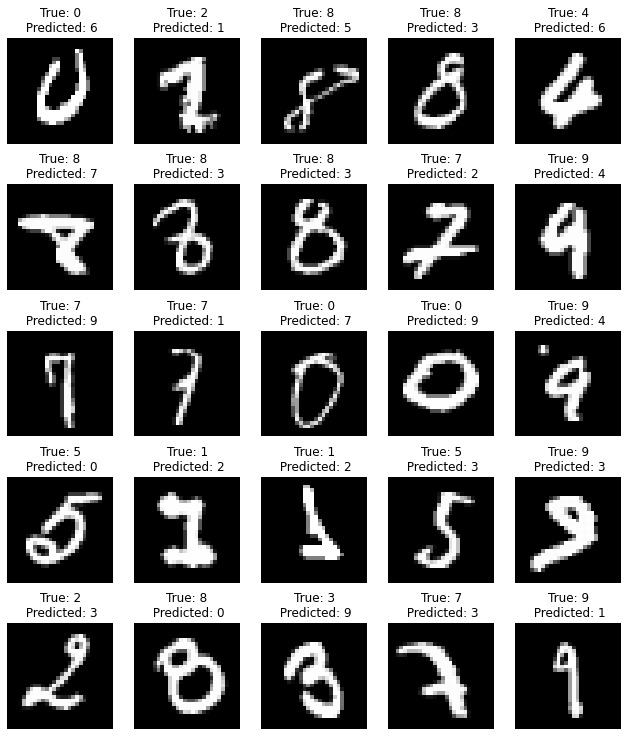

In [69]:
predict()